reference: https://github.com/kzbkzb/Python-AI/blob/main

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import glob

### data process

In [2]:
batch_size = 32 ## 一次读入几个数据
img_height = 256
img_width = 256

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'E:/605Proj/test_code/Train',  ## directory
    validation_split= 0.,#2, ##0.2, ###
    #subset="training",
    #seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 250 files belonging to 5 classes.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'E:/605Proj/test_code/Valid',
    validation_split=0.,
#    subset="validation",
#    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 41 files belonging to 5 classes.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 32 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

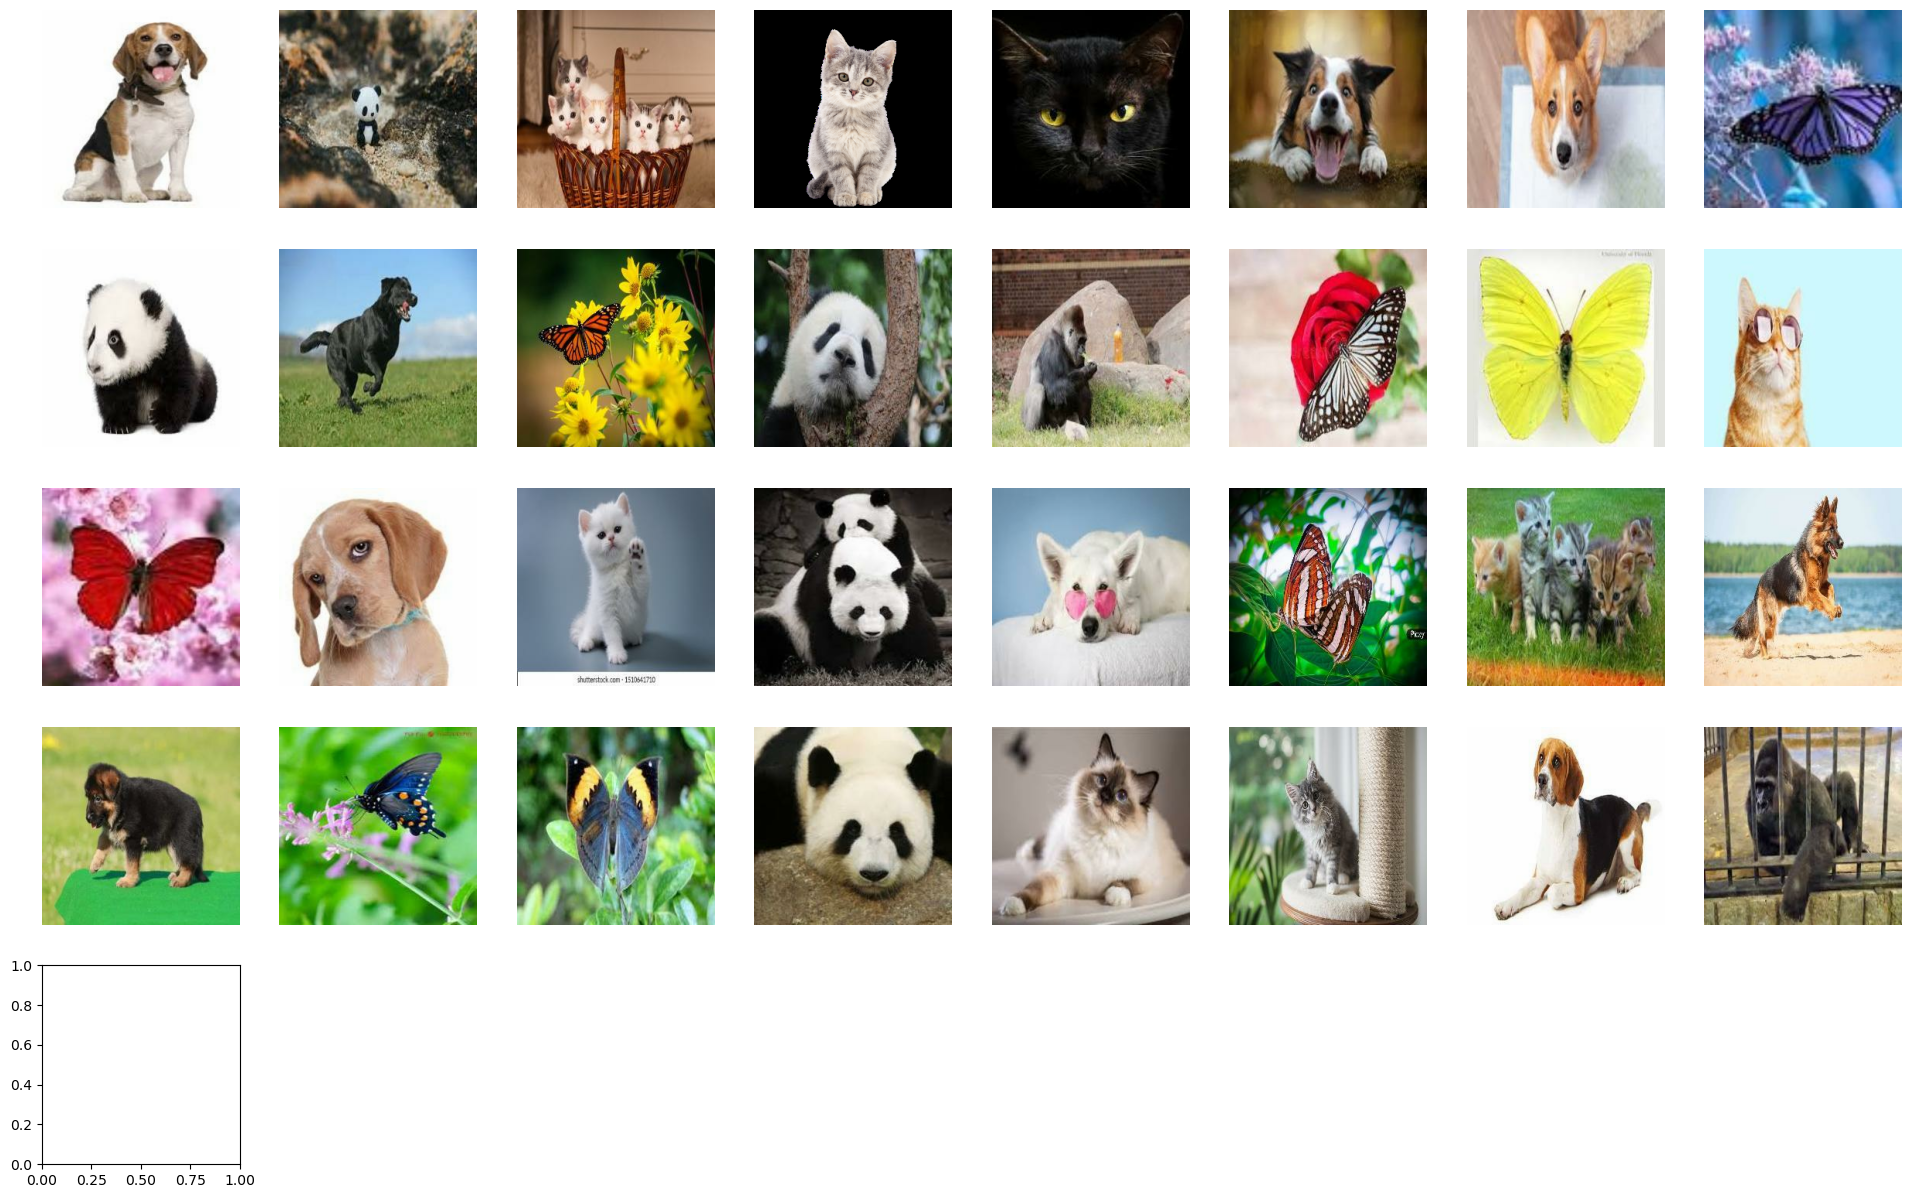

In [21]:
fig = plt.figure(figsize=(24, 15)) # new blank figure
gs = fig.add_gridspec(nrows=5, ncols=8) # grid of plot axes

j = 0
for image, labels in val_ds:
    for i in range(40):
        ax = fig.add_subplot(gs[i // 8, i % 8])
        ax.imshow(images[i].numpy())
#        img_array = tf.expand_dims(images[i], 0)
#        predictions = model.predict(img_array)
#        plt.title(class_names[np.argmax(predictions)])
        ax.axis('off')
        j += 1
         


In [5]:
class_names = train_ds.class_names
print(class_names)

['Butterfly', 'Cat', 'Dog', 'Gorilla', 'Panda']


In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


### Model

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image,label):
    return (image/256.0,label)

# 归一化处理
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

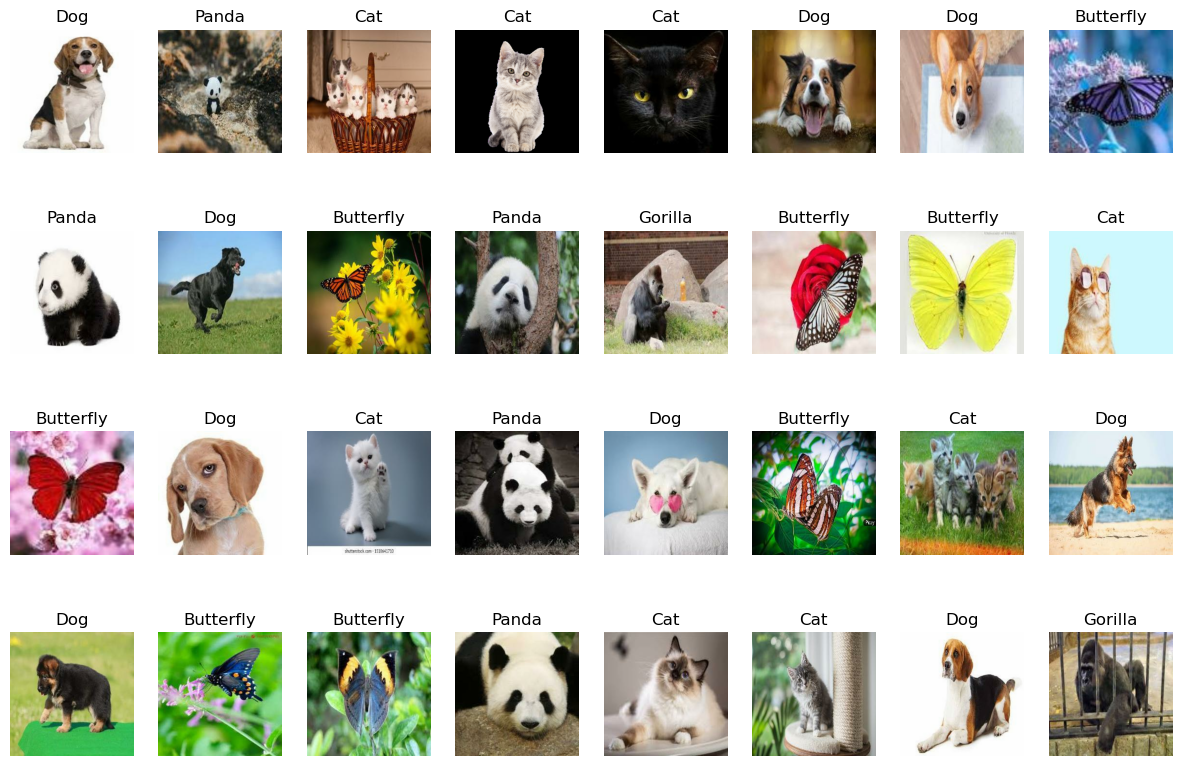

In [8]:
plt.figure(figsize=(15, 10))  # 图形的宽为15高为10

for images, labels in train_ds.take(1):
    for i in range(32):
        
        ax = plt.subplot(4, 8, i + 1) 
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

### VG-16 Network

In [102]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block1_pool')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block2_pool')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block3_pool')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block4_pool')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block5_pool')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(1000, (img_width, img_height, 3))
#model.summary()

In [103]:
model.compile(optimizer="adam",
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

In [104]:
from tqdm import tqdm
import tensorflow.keras.backend as K

epochs = 2
lr     = 1e-4

# 记录训练数据，方便后面的分析
history_train_loss     = []
history_train_accuracy = []
history_val_loss       = []
history_val_accuracy   = []

for epoch in range(epochs):
    train_total = len(train_ds)
    val_total   = len(val_ds)
    
    """
    total：预期的迭代数目
    ncols：控制进度条宽度
    mininterval：进度更新最小间隔，以秒为单位（默认值：0.1）
    """
    with tqdm(total=train_total, desc=f'Epoch {epoch + 1}/{epochs}',mininterval=1,ncols=100) as pbar:
        
        lr = lr*0.92
        K.set_value(model.optimizer.lr, lr)
        
        for image,label in train_ds:      
            """
            训练模型，简单理解train_on_batch就是：它是比model.fit()更高级的一个用法
            """
            history = model.train_on_batch(image,label)
            
            train_loss     = history[0]
            train_accuracy = history[1]
            
            pbar.set_postfix({"loss": "%.4f"%train_loss,
                              "accuracy":"%.4f"%train_accuracy,
                              "lr": K.get_value(model.optimizer.lr)})
            pbar.update(1)
        history_train_loss.append(train_loss)
        history_train_accuracy.append(train_accuracy)
            
#    print('开始验证！')
    
    with tqdm(total=val_total, desc=f'Epoch {epoch + 1}/{epochs}',mininterval=0.3,ncols=100) as pbar:

        for image,label in val_ds:      
            
            history = model.test_on_batch(image,label)
            
            val_loss     = history[0]
            val_accuracy = history[1]
            
            pbar.set_postfix({"loss": "%.4f"%val_loss,
                              "accuracy":"%.4f"%val_accuracy})
            pbar.update(1)
        history_val_loss.append(val_loss)
        history_val_accuracy.append(val_accuracy)
            
 #   print('结束验证！')
    print("验证loss为：%.4f"%val_loss)
    print("验证准确率为：%.4f"%val_accuracy)

Epoch 1/2: 100%|████████████████████████| 2/2 [00:11<00:00,  5.77s/it, loss=3.2361, accuracy=0.1111]


验证loss为：3.2361
验证准确率为：0.1111


Epoch 2/2: 100%|████████████████████████| 2/2 [00:12<00:00,  6.13s/it, loss=1.8323, accuracy=0.3333]

验证loss为：1.8323
验证准确率为：0.3333


### evaluation

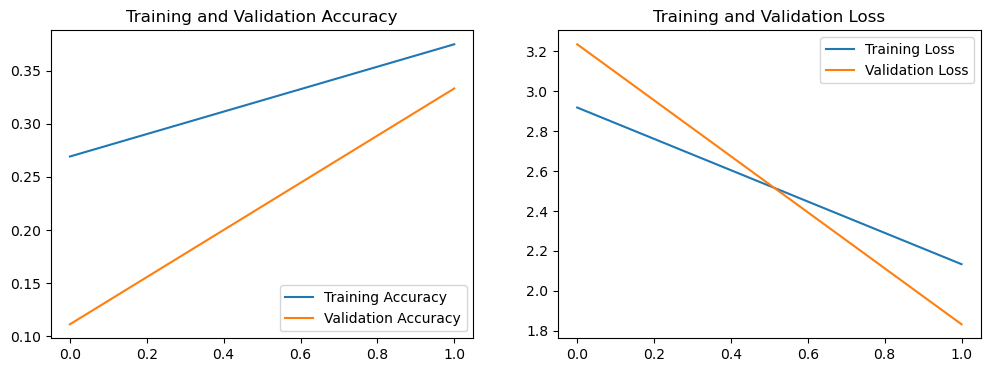

In [105]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, history_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, history_val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_train_loss, label='Training Loss')
plt.plot(epochs_range, history_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# ## save model
# model.save('path/model.h5')
# ## load model
# new_model = tf.keras.models.load_model('path/model.h5')

### predict

1/1 [==============================] - 0s 380ms/step


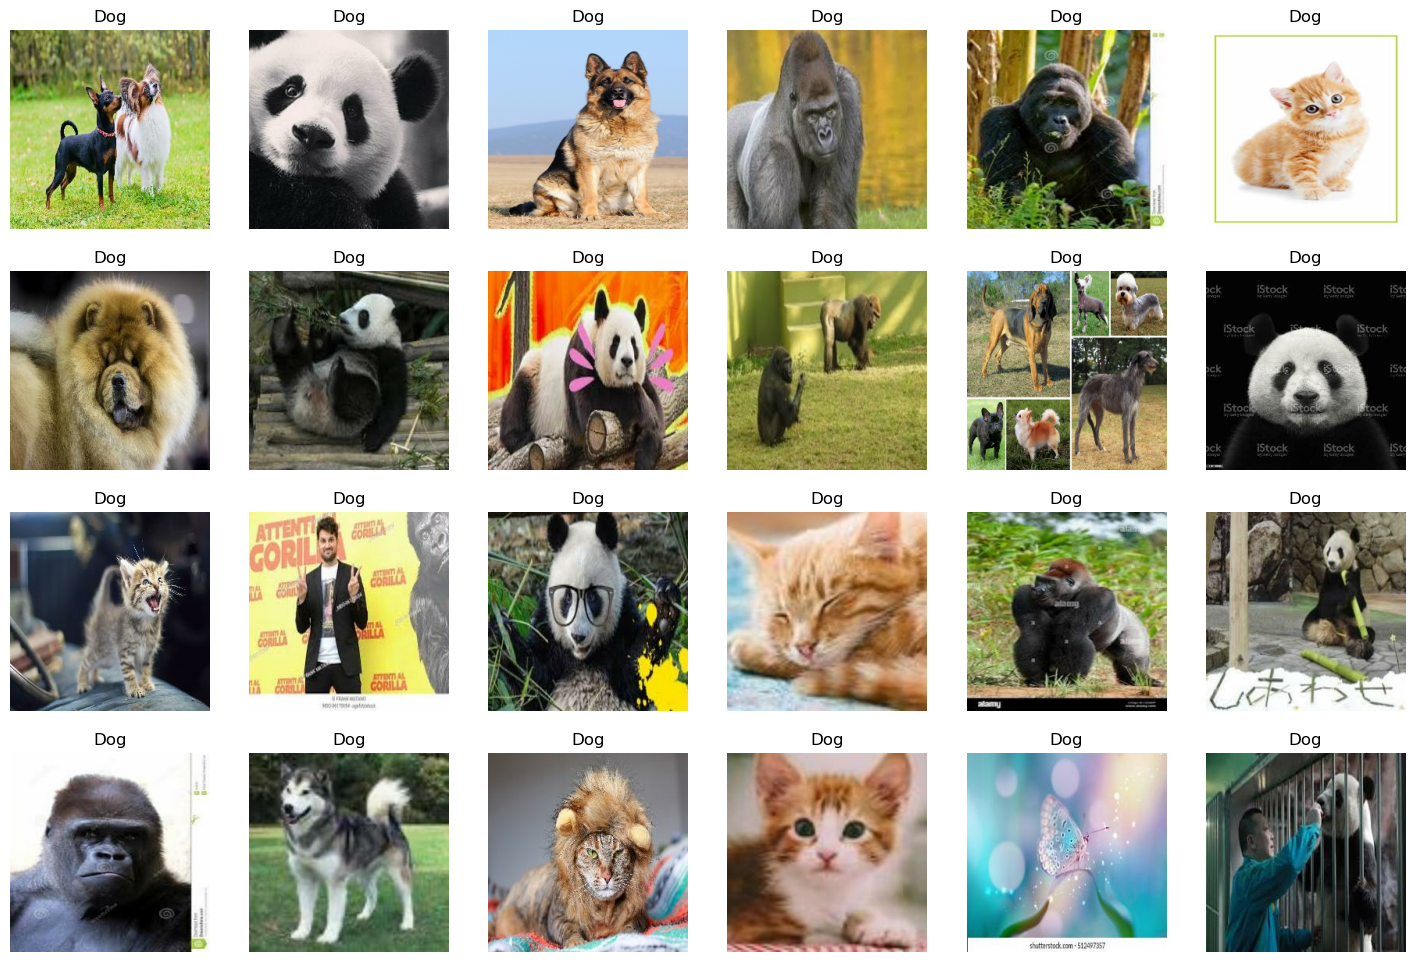

In [107]:
plt.figure(figsize=(18, 12))  # 图形的宽为18高为5
#plt.suptitle("预测结果展示")

for images, labels in val_ds:
    for i in range(24):
        ax = plt.subplot(4,6, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy())
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        predictions = model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")

### Xception

In [69]:
batch_size = 32
img_height = 256
img_width  = 256

In [71]:
# data_dir = "E:/605Proj/test_code/Train"
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="training",
#     seed=12,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

Found 250 files belonging to 5 classes.
Using 200 files for training.


In [73]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=12,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

Found 250 files belonging to 5 classes.
Using 50 files for validation.


In [74]:
# for image_batch, labels_batch in train_ds:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

(32, 256, 256, 3)
(32,)


In [75]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(preprocess_image)    # 这里可以设置预处理函数
#     .batch(batch_size)           # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
#     .map(val_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)         # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

In [76]:
#====================================#
#     Xception的网络部分
#====================================#
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Activation,Conv2D,SeparableConv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions


def Xception(input_shape = [256,256,3],classes=1000):

    img_input = Input(shape=input_shape)
    
    #=================#
    #   Entry flow
    #=================#
    #  block1
    # 256,256,3 -> 149,149,64
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)


    # block2
    # 149,149,64 -> 75,75,128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    # block3
    # 75,75,128 -> 38,38,256
    residual = Conv2D(256, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    # block4
    # 38,38,256 -> 19,19,728
    residual = Conv2D(728, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    #=================#
    # Middle flow
    #=================#
    # block5--block12
    # 19,19,728 -> 19,19,728
    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    #=================#
    #    Exit flow
    #=================#
    # block13
    # 19,19,728 -> 10,10,1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    # block14
    # 10,10,1024 -> 10,10,2048
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='xception')

    return model

In [77]:
model = Xception()
# 打印模型信息
#model.summary()

In [78]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=300,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [79]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

In [80]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 112s 14s/step - loss: 6.1432 - accuracy: 0.3050 - val_loss: 6.8987 - val_accuracy: 0.2800
Epoch 2/10
7/7 [==============================] - 103s 14s/step - loss: 4.5146 - accuracy: 0.5450 - val_loss: 6.8868 - val_accuracy: 0.3800
Epoch 3/10
7/7 [==============================] - 99s 16s/step - loss: 2.6523 - accuracy: 0.6300 - val_loss: 6.8689 - val_accuracy: 0.3200
Epoch 4/10
7/7 [==============================] - 98s 14s/step - loss: 1.4550 - accuracy: 0.7150 - val_loss: 6.8451 - val_accuracy: 0.3200
Epoch 5/10
7/7 [==============================] - 98s 14s/step - loss: 0.9184 - accuracy: 0.7900 - val_loss: 6.8162 - val_accuracy: 0.3200
Epoch 6/10
7/7 [==============================] - 98s 14s/step - loss: 0.4952 - accuracy: 0.8700 - val_loss: 6.7825 - val_accuracy: 0.3200
Epoch 7/10
7/7 [==============================] - 98s 14s/step - loss: 0.2331 - accuracy: 0.9500 - val_loss: 6.7460 - val_accuracy: 0.3200
Epoch 8/10
7/7 [=========

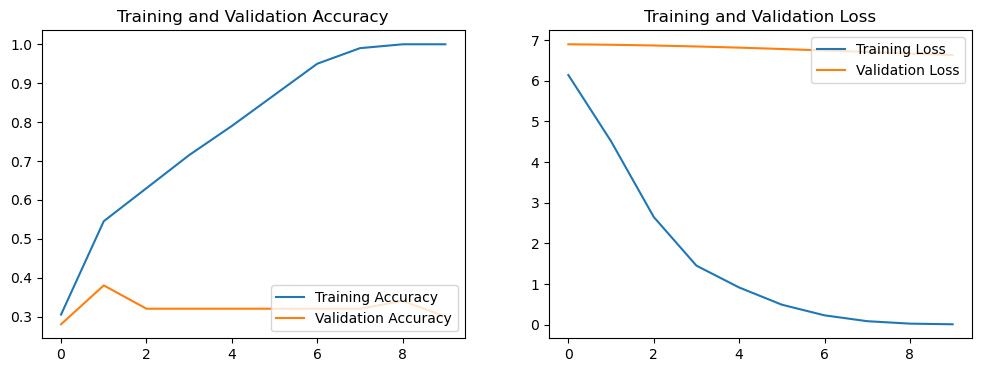

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [90]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

#plot_cm(val_label, val_pre)

1/1 [==============================] - 0s 156ms/step


In [92]:
conf_numpy = confusion_matrix(val_label, val_pre)
lst = class_names
conf_df = pd.DataFrame(conf_numpy, index=lst,columns=lst)
conf_df

Butterfly  Cat  Dog  Gorilla  Panda
Butterfly          0    6    0        0      0
Cat                0   15    0        0      0
Dog                0   16    0        0      0
Gorilla            0    9    0        0      0
Panda              0    4    0        0      0

Text(0.5, 23.52222222222222, 'pre')

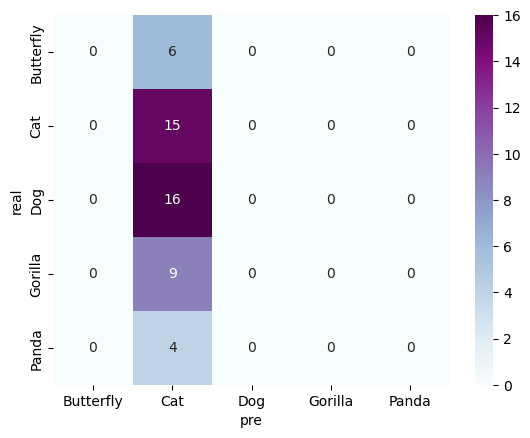

In [93]:
#plt.figure(figsize=(8,7))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
#plt.title('混淆矩阵',fontsize=15)
plt.ylabel('real')#,fontsize=14)
plt.xlabel('pre')#,fontsize=14)

1/1 [==============================] - 0s 131ms/step


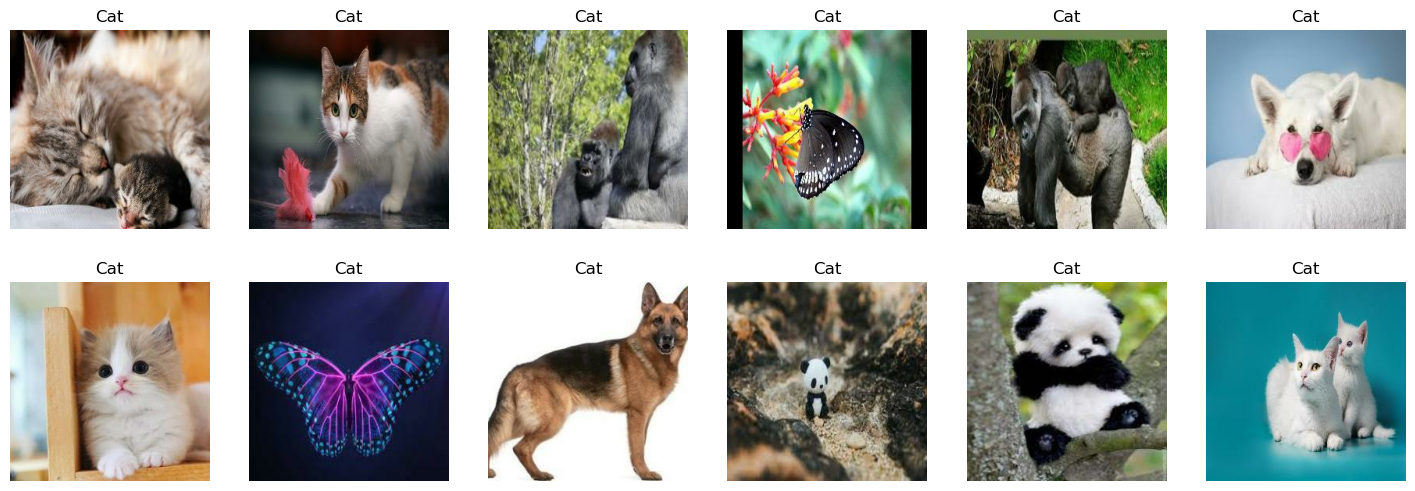

In [94]:
plt.figure(figsize=(18, 6))  # 图形的宽为18高为5

for images, labels in val_ds:
    for i in range(12):
        ax = plt.subplot(2,6, i+1)
        
        img_truncated = np.clip(images[i].numpy(), 0, 255).astype(np.uint8)
        plt.imshow(img_truncated)
 
        img_array = tf.expand_dims(images[i], 0)     
        prediction = model.predict(img_array)
        
        plt.title(class_names[np.argmax(prediction)])

        plt.axis("off")

## 配置GPU

In [158]:
'''
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")
    
# 打印显卡信息，确认GPU可用
print(gpus)
'''

'\nimport tensorflow as tf\ngpus = tf.config.list_physical_devices("GPU")\n\nif gpus:\n    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用\n    tf.config.set_visible_devices([gpus[0]],"GPU")\n    \n# 打印显卡信息，确认GPU可用\nprint(gpus)\n'

GPU（图形处理单元）通常被认为是一种并行计算的强大工具。GPU 是设计用来处理图形渲染任务的硬件，但由于其并行计算能力，它在许多其他领域，尤其是深度学习和科学计算中也得到了广泛的应用。

In [12]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os,PIL
import tensorflow as tf
import matplotlib.pyplot as plt

# cnn

In [108]:
num_classes = len(class_names)

"""
关于卷积核的计算不懂的可以参考文章：https://blog.csdn.net/qq_38251616/article/details/114278995
"""

model = models.Sequential([
#    layers.experimental.preprocessing.Rescaling(1./256, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 230400)           

In [109]:
# 设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 9s 948ms/step - loss: 7.4791 - accuracy: 0.1960 - val_loss: 1.6552 - val_accuracy: 0.2195
Epoch 2/10
8/8 [==============================] - 7s 912ms/step - loss: 1.4669 - accuracy: 0.4720 - val_loss: 1.5172 - val_accuracy: 0.3659
Epoch 3/10
8/8 [==============================] - 7s 913ms/step - loss: 1.1402 - accuracy: 0.5800 - val_loss: 1.4486 - val_accuracy: 0.3659
Epoch 4/10
8/8 [==============================] - 7s 915ms/step - loss: 0.8440 - accuracy: 0.7040 - val_loss: 1.2957 - val_accuracy: 0.5122
Epoch 5/10
8/8 [==============================] - 7s 930ms/step - loss: 0.5300 - accuracy: 0.8320 - val_loss: 1.5528 - val_accuracy: 0.5122
Epoch 6/10
8/8 [==============================] - 7s 918ms/step - loss: 0.3052 - accuracy: 0.9000 - val_loss: 1.9109 - val_accuracy: 0.4878
Epoch 7/10
8/8 [==============================] - 7s 928ms/step - loss: 0.1864 - accuracy: 0.9440 - val_loss: 1.4905 - val_accuracy: 0.5854
Epoch 8/10
8/8 [====

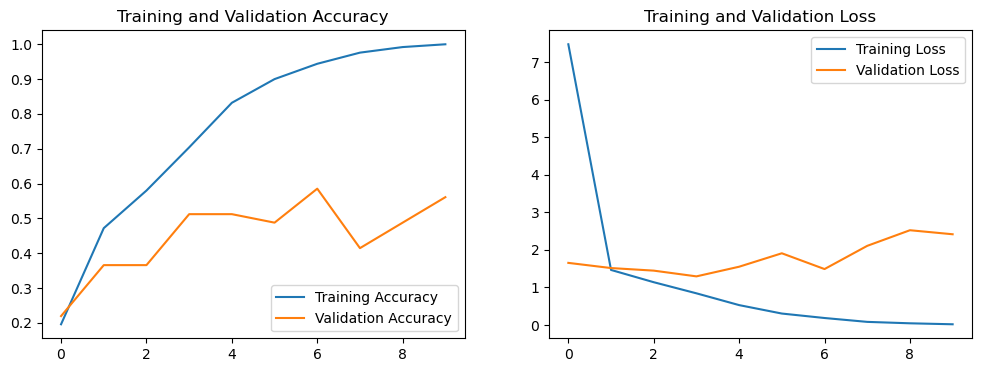

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 51ms/step


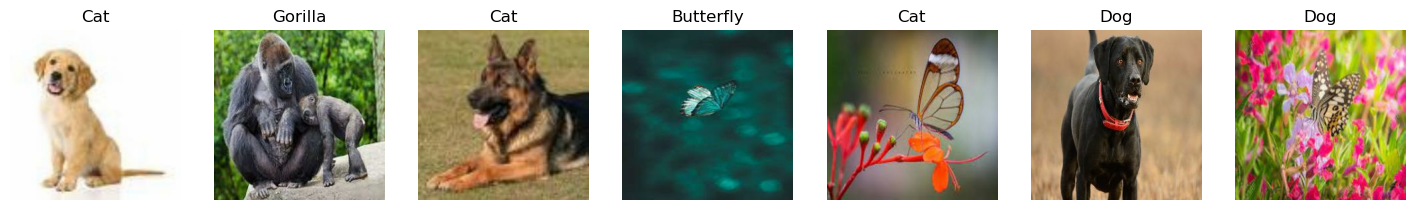

In [115]:
plt.figure(figsize=(18, 3))  # 图形的宽为18高为5

for images, labels in val_ds:
    for i in range(7):
        ax = plt.subplot(1,7, i+1)
        
        plt.imshow(images[i])
 
        img_array = tf.expand_dims(images[i], 0)     
        prediction = model.predict(img_array)
        
        plt.title(class_names[np.argmax(prediction)])

        plt.axis("off")